# Predict hiking times based on GPX tracks

We attempt to predict the walking times and durations for hikes based on GPX files using recurrent neural networks. Using personal GPX records as input, the outputs are personalized as well.

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import h5py
import nn_uncertainty_estimation as nn_ue

import gpx_stats
import utils

print(tf.__version__)

2021-10-04 22:51:49.921404: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.1


### Load data

Load the dataset that was prepared by running the following command in a shell:

`run prepareData.py '~/GPX-Tracks' 'Wandern'`

In [2]:
train_dataset_file = "hiking_data_training.hdf5"
test_dataset_file = "hiking_data_test.hdf5"

Convert data to a pandas dataframe:

In [3]:
def read_hdf5_to_dict(file_name):
    hdf5_data = h5py.File(file_name, "r")
    hdf5_data_dict = {}
    for name in gpx_stats.GpxSegmentStats.get_header():
        if name == "Path":
            hdf5_data_dict[name] = [
                gpx_stats.PathFeature(data) for data in hdf5_data[name]
            ]
        else:
            hdf5_data_dict[name] = hdf5_data[name][...]

    hdf5_data.close()
    return hdf5_data_dict


train_hdf5_data_dict = read_hdf5_to_dict(train_dataset_file)
test_hdf5_data_dict = read_hdf5_to_dict(test_dataset_file)

path_features_shape = train_hdf5_data_dict["Path"][0].shape

train_dataset = pd.DataFrame.from_dict(train_hdf5_data_dict)
test_dataset = pd.DataFrame.from_dict(test_hdf5_data_dict)

train_dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill,Path
8440,83.588441,86.214619,172.0,172.0,0.0,0.000000,19.199992,<gpx_stats.PathFeature object at 0x7f79178b8f70>
8441,80.728736,81.541295,89.0,89.0,0.0,11.266683,0.000000,<gpx_stats.PathFeature object at 0x7f79178b8fd0>
8442,51.561229,54.318354,95.0,95.0,0.0,0.000000,16.533325,<gpx_stats.PathFeature object at 0x7f79178b9040>
8443,56.531630,58.885615,66.0,68.0,0.0,0.000000,16.200000,<gpx_stats.PathFeature object at 0x7f79178b90d0>
8444,50.151807,50.153846,34.0,34.0,0.0,0.000000,0.200000,<gpx_stats.PathFeature object at 0x7f79178b9130>


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [4]:
data_columns = ["Path"]
label_columns = ["MovingTime"]
train_labels_data = []
test_labels_data = []

train_data = train_dataset[data_columns]
train_labels = train_dataset[label_columns]

test_data = test_dataset[data_columns]
test_labels = test_dataset[label_columns]

train_paths_as_array = gpx_stats.convert_paths_to_array(train_data["Path"])
test_paths_as_array = gpx_stats.convert_paths_to_array(test_data["Path"])

Filter paths with `NaN` entries:

In [5]:
train_nan_mask = np.any(np.isnan(train_paths_as_array), axis=(1, 2))
test_nan_mask = np.any(np.isnan(test_paths_as_array), axis=(1, 2))

train_paths_as_array = train_paths_as_array[~train_nan_mask]
train_labels = train_labels[~train_nan_mask]

test_paths_as_array = test_paths_as_array[~test_nan_mask]
test_labels = test_labels[~test_nan_mask]

## The model

### Build the model

Let's build our model. It consists of a few 1d convolutional layers, following by two LSTM layers and two dense layers. The 1d convolutional layers provide some preprocessing of the tracks and are numerially very cheap. As we only have few tracks available, reducing the number of parameters in the model helps to avoid overfitting. The last fully connected layer outputs duration, moving time and stopped time. The model building steps are wrapped in a function, `build_model`, for convencience.

In [6]:
learning_rate = 0.001
batch_size = 256


def build_model():
    path_inputs = layers.Input(shape=path_features_shape, name="path_inputs")
    conv1 = layers.Conv1D(
        filters=6, kernel_size=3, padding="same", activation=tf.nn.relu
    )(path_inputs)
    conv2 = layers.Conv1D(
        filters=12, kernel_size=3, padding="same", activation=tf.nn.relu
    )(conv1)
    bn1 = layers.BatchNormalization()(conv2)
    conv3 = layers.Conv1D(
        filters=24, kernel_size=3, padding="same", activation=tf.nn.relu
    )(bn1)
    conv4 = layers.Conv1D(
        filters=6, kernel_size=3, padding="same", activation=tf.nn.relu
    )(conv3)
    bn2 = layers.BatchNormalization()(conv4)

    lstm1 = layers.LSTM(16, return_sequences=True)(bn2)
    dropout = layers.Dropout(0.25)(lstm1)
    lstm2 = layers.LSTM(16, return_sequences=False)(dropout)
    dropout2 = layers.Dropout(0.25)(lstm2)
    dense1 = layers.Dense(32, activation=tf.nn.relu)(dropout2)

    assert len(train_labels.keys()) == 1
    outputs = layers.Dense(2, activation=None)(dense1)

    return models.Model(inputs=path_inputs, outputs=outputs)


model = build_model()

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# metrics = metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
# loss = tf.keras.losses.MeanSquaredError()
metrics = [
    nn_ue.metrics.AdaptedMseForNllOutput(),
    nn_ue.metrics.AdaptedMaeForNllOutput(),
]
loss = nn_ue.losses.NegativeLogLikelihoodLoss()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

2021-10-04 22:51:51.285594: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-04 22:51:51.347193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 22:51:51.347792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.77GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-04 22:51:51.347822: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-04 22:51:51.350428: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-04 22:51:51.350483: I tensorflow/stream_executor/platform/de

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
path_inputs (InputLayer)     [(None, 25, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 6)             60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 12)            228       
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 12)            48        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 24)            888       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 6)             438       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 6)             24    

### Train the model

Train the model for up to 500 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [8]:
EPOCHS = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=10, min_lr=0.01 * learning_rate
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, verbose=1, restore_best_weights=True
)

callbacks = [reduce_lr, early_stopping]


history = model.fit(
    train_paths_as_array,
    train_labels.values,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
    batch_size=batch_size,
    callbacks=callbacks,
)

2021-10-04 22:51:52.202506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-04 22:51:52.202807: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3592965000 Hz


Epoch 1/500


2021-10-04 22:51:54.022445: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-10-04 22:51:54.349131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-10-04 22:51:54.706743: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-04 22:51:54.971511: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 4s 35ms/step - loss: 1531.4094 - adapted_mse_for_nll: 5499.2549 - adapted_mae_for_nll: 67.1847 - val_loss: 821.0718 - val_adapted_mse_for_nll: 5632.7837 - val_adapted_mae_for_nll: 68.0892
Epoch 2/500
27/27 [==============================] - 0s 10ms/step - loss: 220.6601 - adapted_mse_for_nll: 5507.7046 - adapted_mae_for_nll: 67.2595 - val_loss: 108.9051 - val_adapted_mse_for_nll: 5621.4351 - val_adapted_mae_for_nll: 68.0071
Epoch 3/500
27/27 [==============================] - 0s 10ms/step - loss: 48.1337 - adapted_mse_for_nll: 5473.7241 - adapted_mae_for_nll: 67.0081 - val_loss: 23.3079 - val_adapted_mse_for_nll: 5582.3813 - val_adapted_mae_for_nll: 67.7229
Epoch 4/500
27/27 [==============================] - 0s 10ms/step - loss: 15.0224 - adapted_mse_for_nll: 5423.9019 - adapted_mae_for_nll: 66.6385 - val_loss: 7.5991 - val_adapted_mse_for_nll: 5527.3198 - val_adapted_mae_for_nll: 67.3186
Epoch 5/500
27/27 [==============================] - 0s 

Epoch 36/500
27/27 [==============================] - 0s 10ms/step - loss: 3.8338 - adapted_mse_for_nll: 949.1320 - adapted_mae_for_nll: 21.3119 - val_loss: 3.6561 - val_adapted_mse_for_nll: 943.2713 - val_adapted_mae_for_nll: 21.8217
Epoch 37/500
27/27 [==============================] - 0s 10ms/step - loss: 3.7728 - adapted_mse_for_nll: 864.5489 - adapted_mae_for_nll: 20.3736 - val_loss: 3.6056 - val_adapted_mse_for_nll: 803.7471 - val_adapted_mae_for_nll: 20.1065
Epoch 38/500
27/27 [==============================] - 0s 10ms/step - loss: 3.7547 - adapted_mse_for_nll: 797.5187 - adapted_mae_for_nll: 19.6546 - val_loss: 3.5747 - val_adapted_mse_for_nll: 743.9785 - val_adapted_mae_for_nll: 19.3206
Epoch 39/500
27/27 [==============================] - 0s 10ms/step - loss: 3.6939 - adapted_mse_for_nll: 741.4044 - adapted_mae_for_nll: 19.0721 - val_loss: 3.5962 - val_adapted_mse_for_nll: 686.6693 - val_adapted_mae_for_nll: 18.7910
Epoch 40/500
27/27 [==============================] - 0s 10m

Epoch 71/500
27/27 [==============================] - 0s 11ms/step - loss: 3.3624 - adapted_mse_for_nll: 389.5451 - adapted_mae_for_nll: 14.1519 - val_loss: 3.3890 - val_adapted_mse_for_nll: 390.2996 - val_adapted_mae_for_nll: 15.2294
Epoch 72/500
27/27 [==============================] - 0s 11ms/step - loss: 3.3430 - adapted_mse_for_nll: 378.1696 - adapted_mae_for_nll: 13.9444 - val_loss: 3.3088 - val_adapted_mse_for_nll: 349.7379 - val_adapted_mae_for_nll: 13.7286
Epoch 73/500
27/27 [==============================] - 0s 11ms/step - loss: 3.3402 - adapted_mse_for_nll: 378.1890 - adapted_mae_for_nll: 13.9226 - val_loss: 3.4013 - val_adapted_mse_for_nll: 378.6057 - val_adapted_mae_for_nll: 14.0215
Epoch 74/500
27/27 [==============================] - 0s 11ms/step - loss: 3.3427 - adapted_mse_for_nll: 378.7431 - adapted_mae_for_nll: 13.9836 - val_loss: 3.3814 - val_adapted_mse_for_nll: 389.2043 - val_adapted_mae_for_nll: 15.1400
Epoch 75/500
27/27 [==============================] - 0s 10m

Epoch 106/500
27/27 [==============================] - 0s 11ms/step - loss: 3.2356 - adapted_mse_for_nll: 321.9723 - adapted_mae_for_nll: 12.8847 - val_loss: 3.2964 - val_adapted_mse_for_nll: 335.2530 - val_adapted_mae_for_nll: 13.3537
Epoch 107/500
27/27 [==============================] - 0s 10ms/step - loss: 3.2373 - adapted_mse_for_nll: 325.3130 - adapted_mae_for_nll: 12.8427 - val_loss: 3.2920 - val_adapted_mse_for_nll: 330.7178 - val_adapted_mae_for_nll: 13.2557
Epoch 108/500
27/27 [==============================] - 0s 11ms/step - loss: 3.2353 - adapted_mse_for_nll: 324.2655 - adapted_mae_for_nll: 12.8404 - val_loss: 3.3051 - val_adapted_mse_for_nll: 333.8107 - val_adapted_mae_for_nll: 13.1880
Epoch 109/500
27/27 [==============================] - 0s 10ms/step - loss: 3.2245 - adapted_mse_for_nll: 322.7240 - adapted_mae_for_nll: 12.8346 - val_loss: 3.3426 - val_adapted_mse_for_nll: 334.7444 - val_adapted_mae_for_nll: 13.1128
Epoch 110/500
27/27 [==============================] - 0

Visualize the model's training progress using the stats stored in the `history` object.

In [9]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,adapted_mse_for_nll,adapted_mae_for_nll,val_loss,val_adapted_mse_for_nll,val_adapted_mae_for_nll,lr,epoch
122,3.227417,322.105560,12.835428,3.307425,332.314789,13.137607,0.000125,122
123,3.214988,312.842987,12.583578,3.308888,332.258911,13.128220,0.000125,123
124,3.218591,317.074371,12.774253,3.304623,332.381958,13.176262,0.000125,124
125,3.227755,321.109589,12.821503,3.298671,337.291718,13.377128,0.000125,125
126,3.217749,318.392242,12.714126,3.305014,330.834198,13.113894,0.000125,126


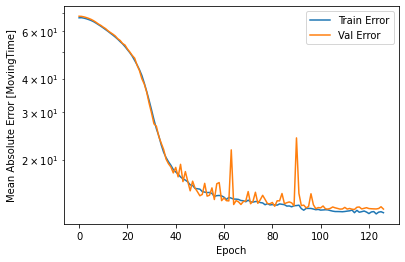

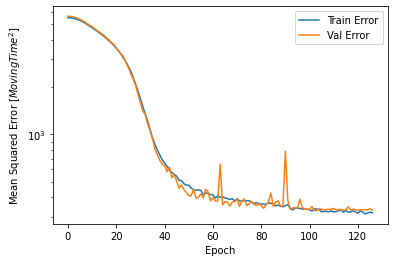

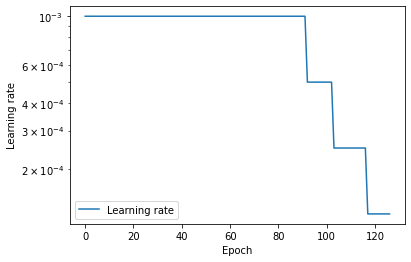

In [10]:
utils.plot_history(history, metrics[0].name, metrics[1].name)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results. The model trains quite well and is slightly better than the simple model discussed in the other notebook.


### Make predictions

Finally, predict walking time values using data in the testing set:

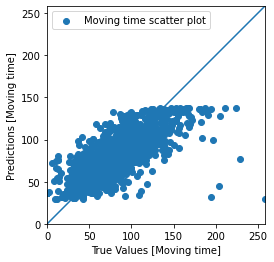

In [11]:
test_predictions = model.predict(test_paths_as_array)

utils.scatter_plot(
    test_labels["MovingTime"].values, test_predictions[:, 0], "Moving time"
)

It looks like our model predicts durations and moving times reasonably well, as the results should be as close to the diagonal as possible. There are interesting gaps in the plots at low times. Let's take a look at the error distribution.

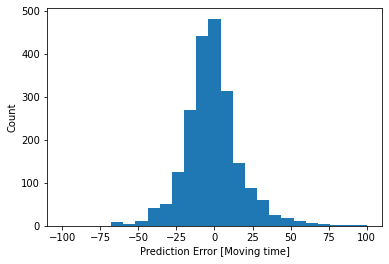

In [12]:
utils.plot_error_hist(
    test_labels["MovingTime"].values, test_predictions[:, 0], "Moving time"
)

It's not quite gaussian, but we might expect that because the number of samples is very small.

Export model for use in inference:

In [13]:
model.save("model_hikingTimePrediction_recurrent")

2021-10-04 22:52:34.812270: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_hikingTimePrediction_recurrent/assets


INFO:tensorflow:Assets written to: model_hikingTimePrediction_recurrent/assets


## Analyze errors

In the following, the predicted errors are analyzed

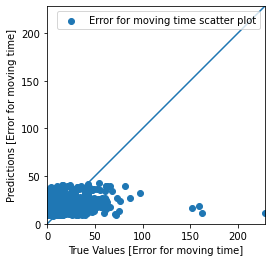

In [14]:
abs_errors_true = np.abs(test_labels["MovingTime"].values - test_predictions[:, 0])
std_errors_pred = np.exp(test_predictions[:, 1] / 2)

utils.scatter_plot(abs_errors_true, std_errors_pred, "Error for moving time")

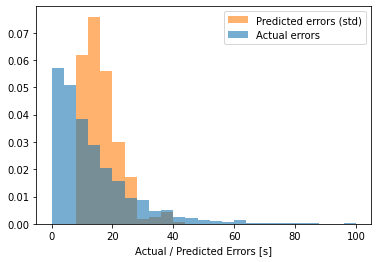

In [15]:
plt.hist(
    [abs_errors_true, std_errors_pred],
    label=["Actual errors", "Predicted errors (std)"],
    density=True,
    bins=25,
    histtype="stepfilled",
    alpha=0.6,
    range=(0, 100),
)
plt.xlabel("Actual / Predicted Errors [s]")
plt.legend()
plt.show()

In [16]:
tf.keras.losses.KLDivergence()(
    abs_errors_true / np.sum(abs_errors_true), std_errors_pred / np.sum(std_errors_pred)
).numpy()

0.3439992

## Comparison of predictions with standard formula for predicting hiking durations

In the following, the predictions are compared with the estimates for hiking durations from a standard formula.

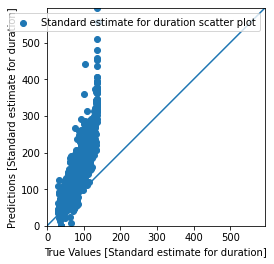

In [17]:
compute_standard_walking_time_vectorized = np.vectorize(
    utils.compute_standard_walking_time
)

standard_estimate_walking_time = compute_standard_walking_time_vectorized(
    test_dataset["Length2d"].values,
    test_dataset["TotalUphill"].values,
    test_dataset["TotalDownhill"].values,
)

utils.scatter_plot(
    test_predictions[:, 0],
    standard_estimate_walking_time,
    "Standard estimate for duration",
)

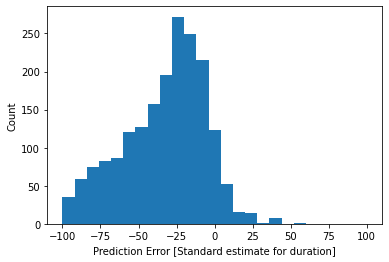

In [18]:
utils.plot_error_hist(
    test_predictions[:, 0],
    standard_estimate_walking_time,
    "Standard estimate for duration",
)

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities).

In [19]:
model.evaluate(test_paths_as_array, test_labels, return_dict=True)

66/66 [==============================] - 1s 3ms/step - loss: 3.4659 - adapted_mse_for_nll: 391.5870 - adapted_mae_for_nll: 13.5761


{'loss': 3.46592116355896,
 'adapted_mse_for_nll': 391.5870361328125,
 'adapted_mae_for_nll': 13.576117515563965}